In [39]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from matplotlib import rcParams
from sklearn.model_selection import GridSearchCV
import plotly.express as px


# EDA

Read the data 

In [40]:
df = pd.read_csv('train.csv')

Quick look at the data 

In [41]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


Get information about the columns, we can see that there are a lot of columns that are numbers but they are are classified as an object and also have no nans

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [43]:
df.shape

(45593, 20)

We'll verify if there are indeed no NaNs, and we can see that the dataset does contain some.

In [44]:
df = df.applymap(lambda x: np.nan if isinstance(x, str) and 'nan' in x.lower() else x)

df.isna().sum()


ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken(min)                   0
dtype: int64

The target column has '(min)' when we need only the number

In [45]:
df = df.rename(columns={'Time_taken(min)': 'target'})

df['target'] = df['target'].str.extract('(\d+)').astype(float)
df['target']

0        24.0
1        33.0
2        26.0
3        21.0
4        30.0
         ... 
45588    32.0
45589    36.0
45590    16.0
45591    26.0
45592    36.0
Name: target, Length: 45593, dtype: float64

Here we convert the numeric columns labeled as object as numeric, then the columns that are dates or hours we convert it into something more useful

In [46]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')


df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")

def calculate_time(data):
    data['Time_Orderd'] = pd.to_timedelta(data['Time_Orderd'])
    data['Time_Order_picked'] = pd.to_timedelta(data['Time_Order_picked'])
    
    data['Time_Order_picked'] = np.where(
        data['Time_Order_picked'] < data['Time_Orderd'],
        data['Order_Date'] + pd.DateOffset(1) + data['Time_Order_picked'],
        data['Order_Date'] + data['Time_Order_picked']
    )
    
    data['Time_Orderd'] = data['Order_Date'] + data['Time_Orderd']
    
    data['Time_Order_picked'] = (data['Time_Order_picked'] - pd.Timestamp('2022-01-01')) // pd.Timedelta('1min')
    data['Time_Orderd'] = (data['Time_Orderd'] - pd.Timestamp('2022-01-01')) // pd.Timedelta('1min')

    return data[['Time_Order_picked', 'Time_Orderd']]

calculate_time(df)



df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID                           45593 non-null  object        
 1   Delivery_person_ID           45593 non-null  object        
 2   Delivery_person_Age          43739 non-null  float64       
 3   Delivery_person_Ratings      43685 non-null  float64       
 4   Restaurant_latitude          45593 non-null  float64       
 5   Restaurant_longitude         45593 non-null  float64       
 6   Delivery_location_latitude   45593 non-null  float64       
 7   Delivery_location_longitude  45593 non-null  float64       
 8   Order_Date                   45593 non-null  datetime64[ns]
 9   Time_Orderd                  43862 non-null  float64       
 10  Time_Order_picked            45593 non-null  int64         
 11  Weatherconditions            44977 non-nu

To plot the distribution of the data

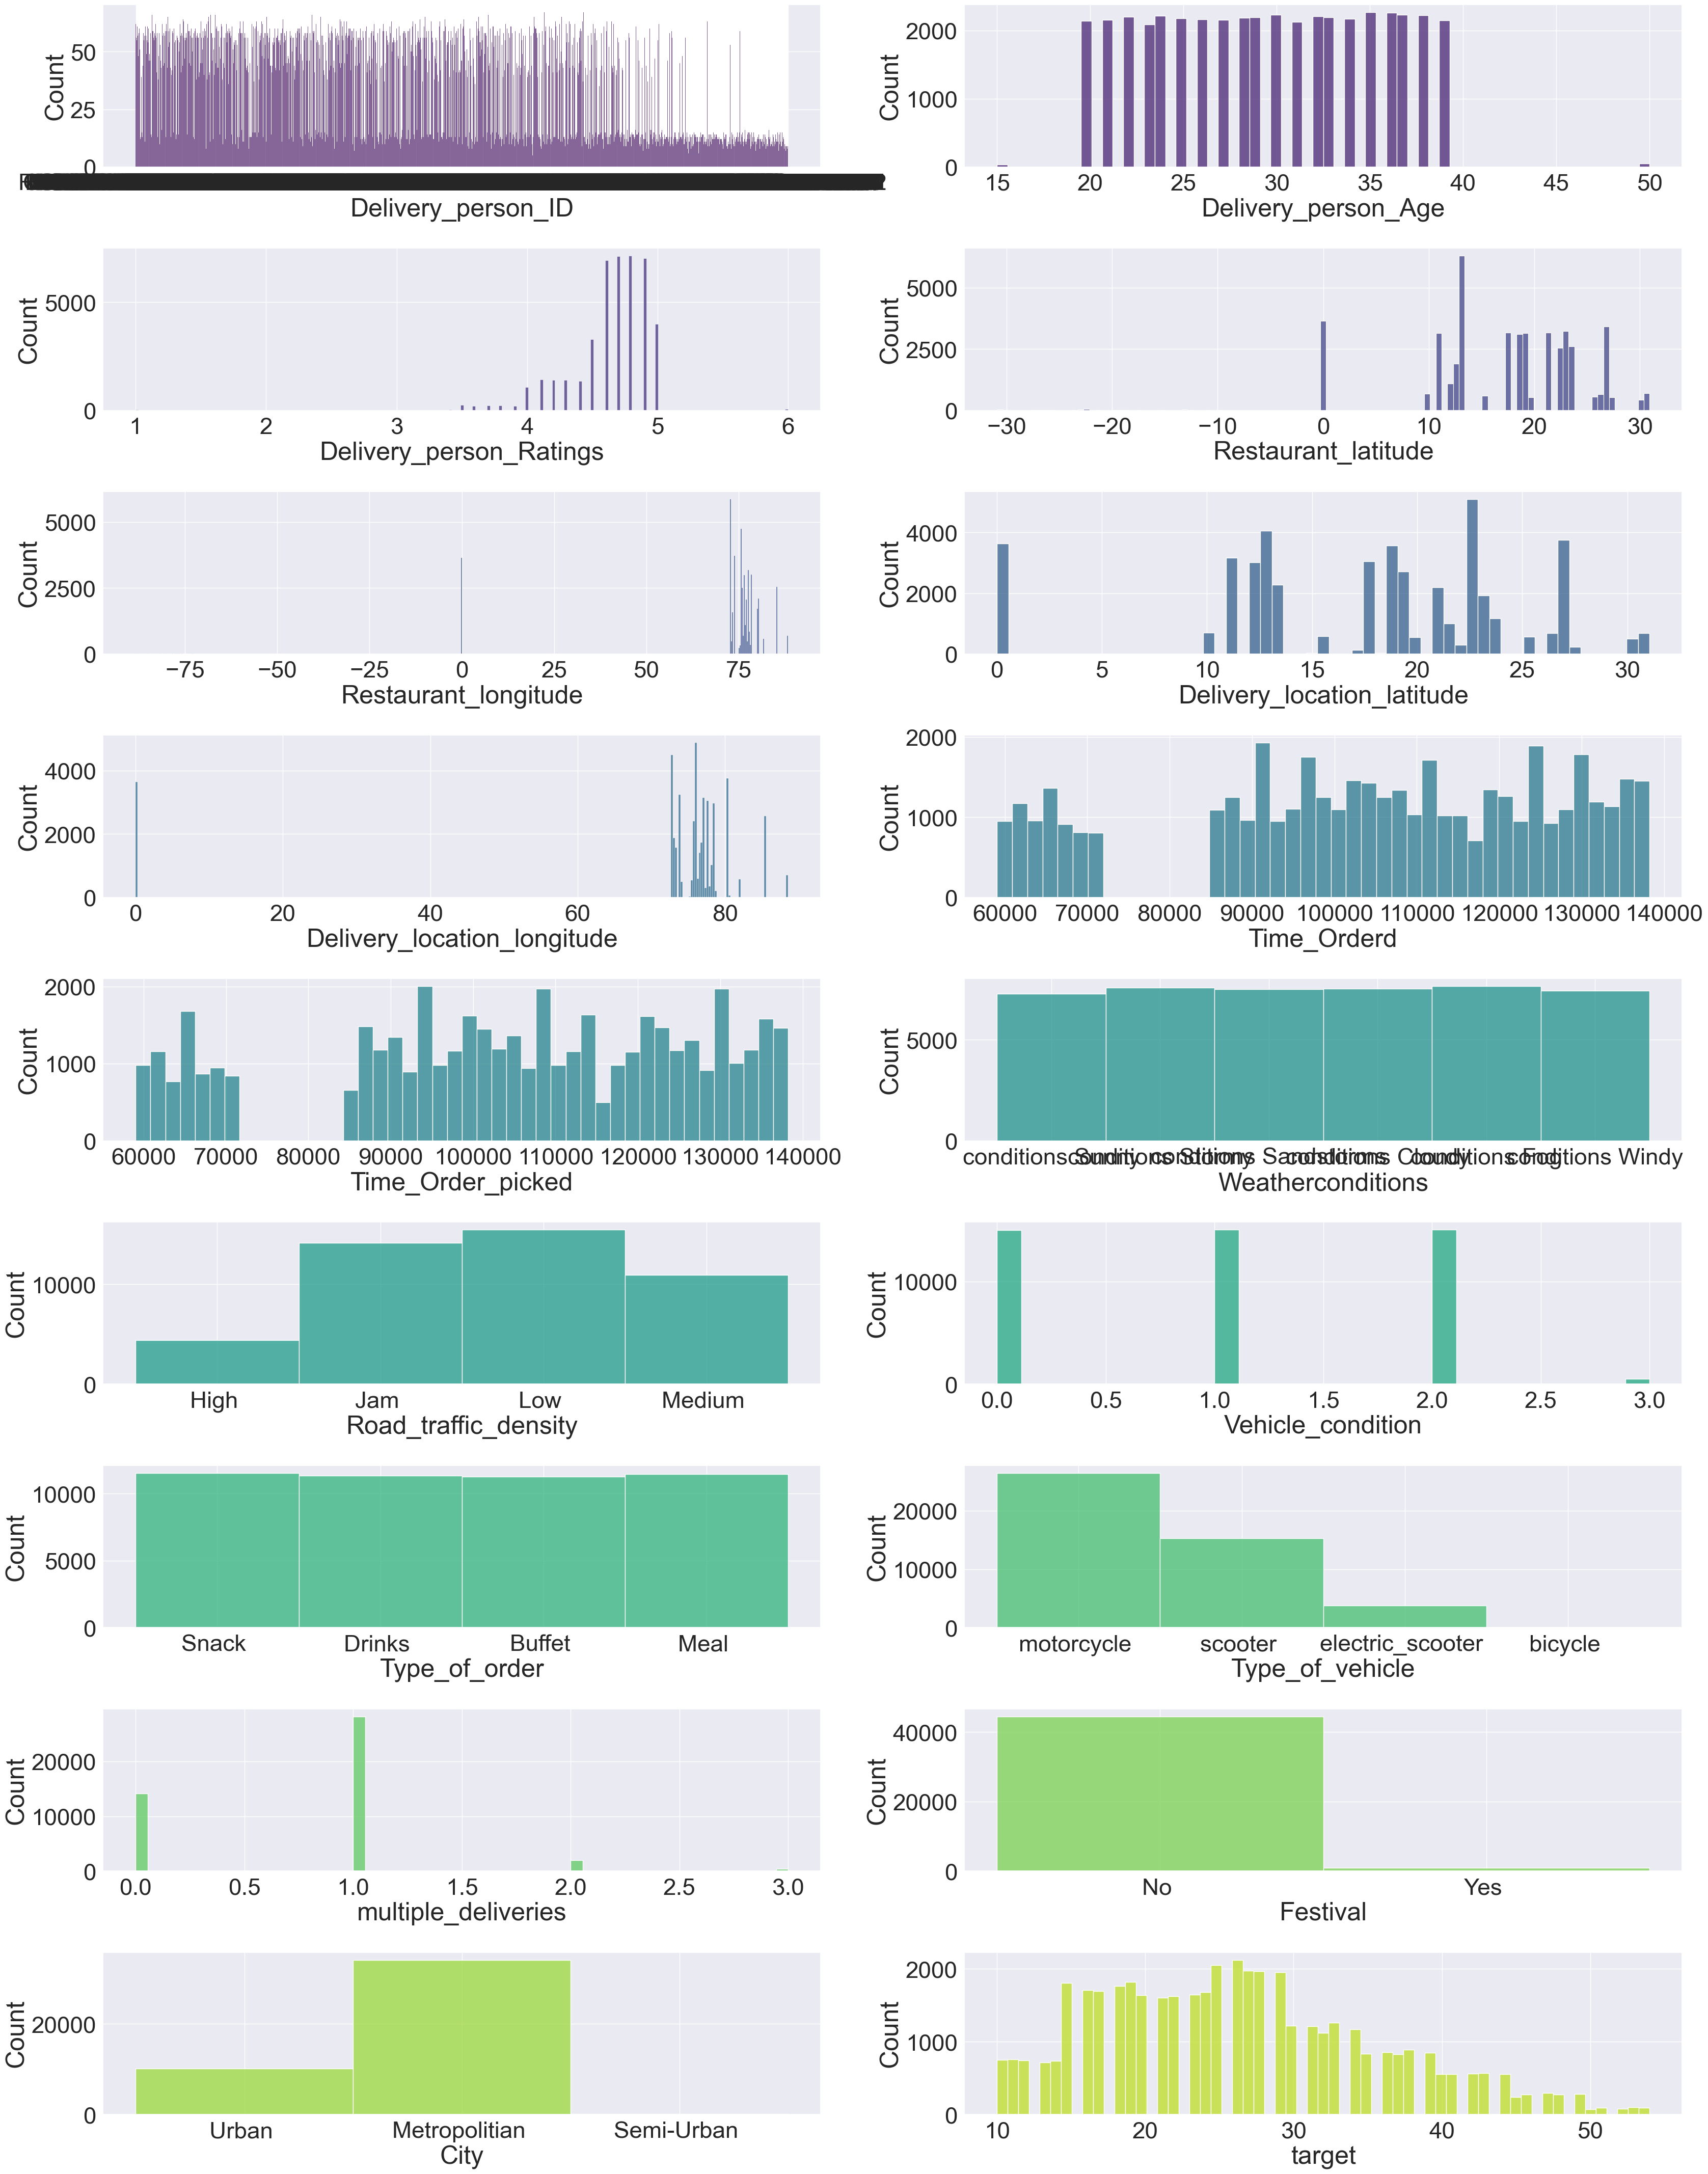

In [47]:
sns.set(font_scale = 3)
rcParams['figure.figsize'] = 40,60
plt.subplots_adjust(hspace=0.5)
palette = sns.color_palette("viridis", as_cmap=True)
feature_columns = ['Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'target']
i = 1

for name in feature_columns:
    plt.subplot(10,2,i)
    sns.histplot(data=df, x=name, color=palette(i/len(df.columns)))
    i = i + 1

# Feature Engineering

Some columns like latitude will not be important to the models because they have no relevant information by themselves but if we get the distance between the restaurant and the delivery location the algorithm can consider it important, the same with time.

In [48]:
def convert_columns(df):
    df['latitude_distance'] = 100 * np.abs(df['Restaurant_latitude'] - df['Delivery_location_latitude'])
    df['latitude_distance'] = np.where(df['latitude_distance'] > 500, np.nan, df['latitude_distance'])

    df['longitude_distance'] = 100 * np.abs(df['Restaurant_longitude'] - df['Delivery_location_longitude'])
    df['longitude_distance'] = np.where(df['longitude_distance'] > 500, np.nan, df['longitude_distance'])
    
    df['distance'] = np.sqrt((df['latitude_distance'])**2 + (df['longitude_distance']))
    
    df['time_diff'] = df['Time_Order_picked'] - df['Time_Orderd']
    
    # df["day"] = df.Order_Date.dt.day
    # df["week"] = df.Order_Date.dt.isocalendar().week
    # df["month"] = df.Order_Date.dt.month
    # df["quarter"] = df.Order_Date.dt.quarter
    #df['day_of_week'] = df.Order_Date.dt.day_of_week.astype(int)
    # df["is_month_start"] = df.Order_Date.dt.is_month_start.astype(int)
    # df["is_month_end"] = df.Order_Date.dt.is_month_end.astype(int)
    # df["is_quarter_start"] = df.Order_Date.dt.is_quarter_start.astype(int)
    # df["is_quarter_end"] = df.Order_Date.dt.is_quarter_end.astype(int)
    df['is_weekend'] = np.where((df.Order_Date.dt.day_of_week.astype(int)).isin([5,6]),1,0)

    df = df.drop(columns='ID', axis=1)

    df = df.drop(columns = 'Order_Date', axis =1 )    
    
    cols = [col for col in df.columns if col != 'target'] + ['target']
    df = df[cols]
    return df

df = convert_columns(df)


Encoder

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

columns_to_encode = ['Delivery_person_ID','Road_traffic_density', 'Weatherconditions', 
                     'Type_of_order', 'Type_of_vehicle', 'Festival', 'City']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

df[columns_to_encode] = encoder.fit_transform(df[columns_to_encode])



As we said columns like latitude or longitude are irrelevant in the correlation, and the distances have an important value but they are the same so we will drop two of them

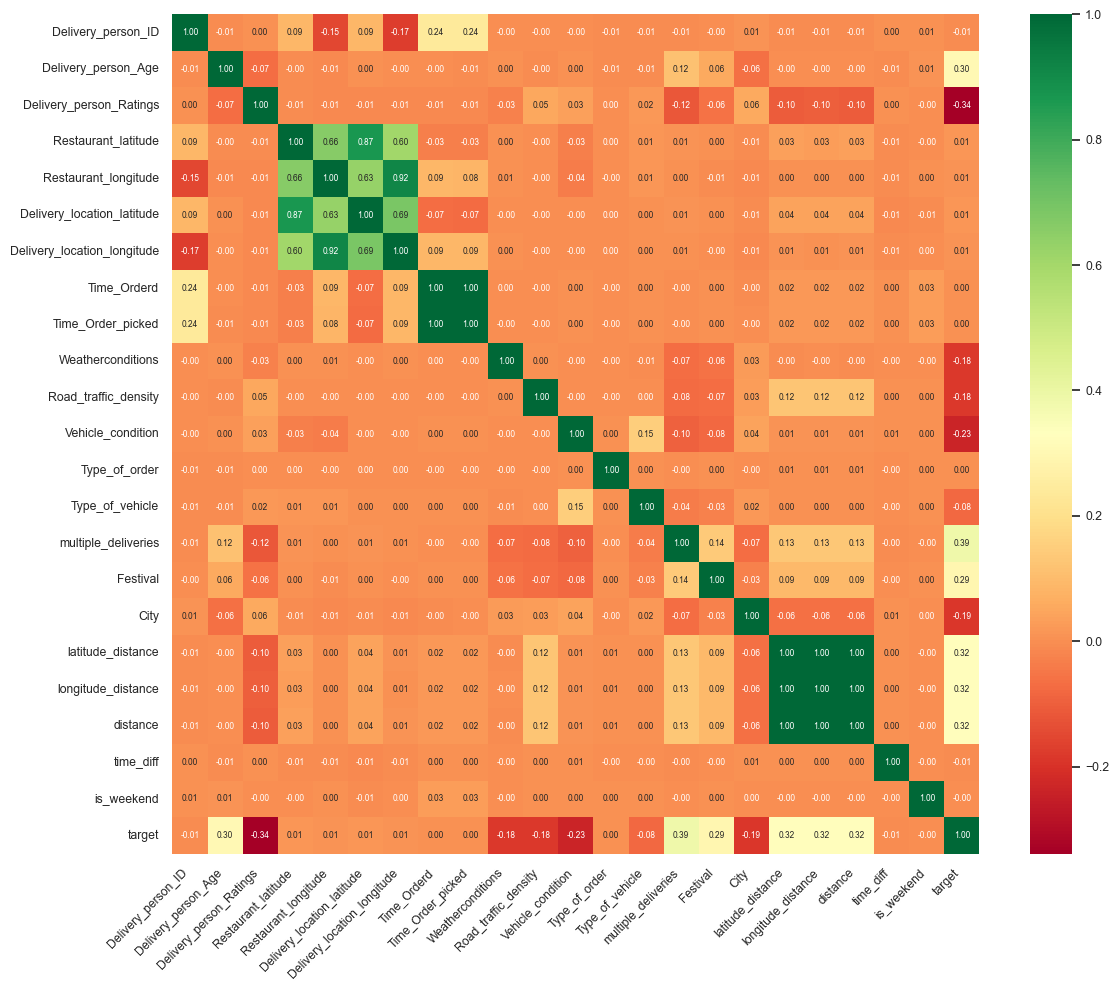

In [50]:
def matrix_corr(data):
    correlation = data.corr()
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=0.8)
    sns.heatmap(correlation, annot=True, fmt=".2f", cbar=True, cmap="RdYlGn", annot_kws={"size": 6})
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

matrix_corr(df)

In [51]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors= 10)
df_imp = imputer.fit_transform(df)
df_imp = pd.DataFrame(df_imp, columns=df.columns)
df_imp[columns_to_encode] = df_imp[columns_to_encode].round(0)

Check the feature importance in a Random Forest

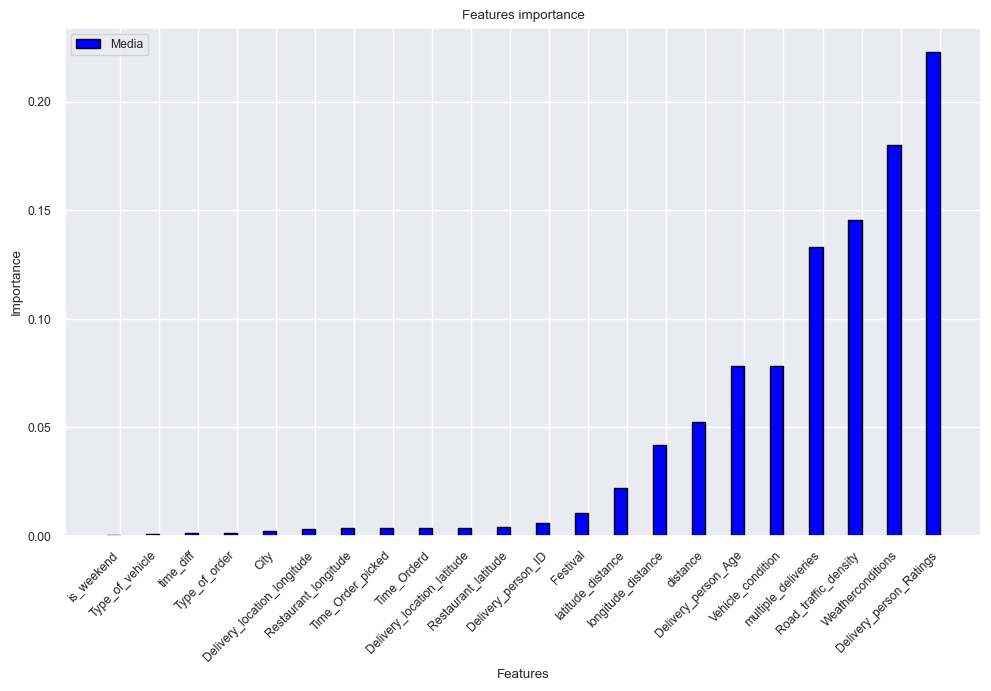

In [52]:
from sklearn.ensemble import RandomForestRegressor
X_imp = df_imp.drop(columns='target', axis = 1)
y_imp = df_imp['target']

model = RandomForestRegressor(max_depth= 12, n_jobs = -1 )
model.fit(X_imp, y_imp)

importances = model.feature_importances_

indices = np.argsort(importances)

plt.figure(figsize=(10, 7))

bar_width = 0.35
r1 = np.arange(X_imp.shape[1])

plt.bar(r1, importances[indices], color='blue', width=bar_width, edgecolor='black', label='Media')

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Features importance')
plt.xticks(r1 + bar_width / 2, X_imp.columns[indices], rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


We will drop the columns that have low importance and almost 0 correlation

In [53]:
columns_to_drop = ['time_diff', 'Type_of_order', 
                   'Delivery_location_latitude', 'Delivery_location_longitude',
                   'Time_Orderd', 'Time_Order_picked', 
                   'Restaurant_latitude', 'Restaurant_longitude',
                   'City', 'latitude_distance',
                   'distance'
                   ]

df = df.drop(columns = columns_to_drop, axis = 1)

In [54]:
df

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Festival,longitude_distance,is_weekend,target
0,637.0,37.0,4.9,4.0,0.0,2,2.0,0.0,0.0,2.0,1,24.0
1,232.0,34.0,4.5,3.0,1.0,2,3.0,1.0,0.0,13.0,0,33.0
2,234.0,23.0,4.4,2.0,2.0,0,2.0,1.0,0.0,1.0,1,26.0
3,397.0,38.0,4.7,4.0,3.0,0,2.0,1.0,0.0,5.0,0,21.0
4,333.0,32.0,4.6,0.0,0.0,1,3.0,1.0,0.0,4.0,1,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...
45588,672.0,30.0,4.8,5.0,0.0,1,2.0,0.0,0.0,1.0,0,32.0
45589,45.0,21.0,4.6,5.0,1.0,0,2.0,1.0,0.0,7.0,0,36.0
45590,326.0,30.0,4.9,0.0,2.0,1,3.0,0.0,0.0,3.0,0,16.0
45591,390.0,20.0,4.7,0.0,0.0,0,2.0,1.0,0.0,4.0,0,26.0


# Model Training

Heatmap of 2 hyperparameters with the results on the train scores and validation scores

In [55]:
def param_heat(results, param_grid, param_x, param_y):

    sns.set(font_scale=1.5)

    param_x_r = param_grid[param_x]
    param_y_r = param_grid[param_y]
    valid_scores = results['mean_test_score'].values.reshape(len(param_y_r), len(param_x_r))
    train_scores = results['mean_train_score'].values.reshape(len(param_y_r), len(param_x_r))

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    sns.heatmap(train_scores, annot=True, xticklabels=param_x_r, yticklabels=param_y_r, cmap='coolwarm', ax=axes[0])
    axes[0].set_title('Train Score')
    axes[0].set_xlabel(param_x)
    axes[0].set_ylabel(param_y)

    sns.heatmap(valid_scores, annot=True, xticklabels=param_x_r, yticklabels=param_y_r, cmap='coolwarm', ax=axes[1])
    axes[1].set_title('Validation Score')
    axes[1].set_xlabel(param_x)
    axes[1].set_ylabel(param_y)

    plt.tight_layout()
    plt.show()


Function to train models and get a dataframe of the information collected in the model training

In [56]:
def training(model, X_train, y_train, param_grid):

    cv = 4

    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1,
                                return_train_score=True, verbose = 1)
    
    grid_search.fit(X_train, y_train)

    cv_results = pd.DataFrame(grid_search.cv_results_)
    
    print('The best hyperparameters are:', grid_search.best_params_)
    print('The best training score is:', cv_results['mean_train_score'].iloc[grid_search.best_index_])
    print('The best score is:', grid_search.best_score_)
    

    return cv_results, grid_search


Applying imputer and correcting its mistakes in the ordinal columns

In [57]:
from sklearn.model_selection import train_test_split
X = df.drop(columns = 'target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42 )

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

integer_columns = ['Weatherconditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_vehicle', 'multiple_deliveries', 'Festival']

X_train_df[integer_columns] = X_train_df[integer_columns].round(0)
X_test_df[integer_columns] = X_test_df[integer_columns].round(0)

X_train = X_train_df.values
X_test = X_test_df.values

## Random Forest 

In [58]:
rf_param = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': range(9,14)
}

rf_results, rf = training(RandomForestRegressor(max_features = 'sqrt', 
                                                min_samples_leaf= 10, n_jobs = -1), 
                                                X_train, y_train, rf_param)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
The best hyperparameters are: {'max_depth': 13, 'n_estimators': 150}
The best training score is: 0.826037585946743
The best score is: 0.798068452404634


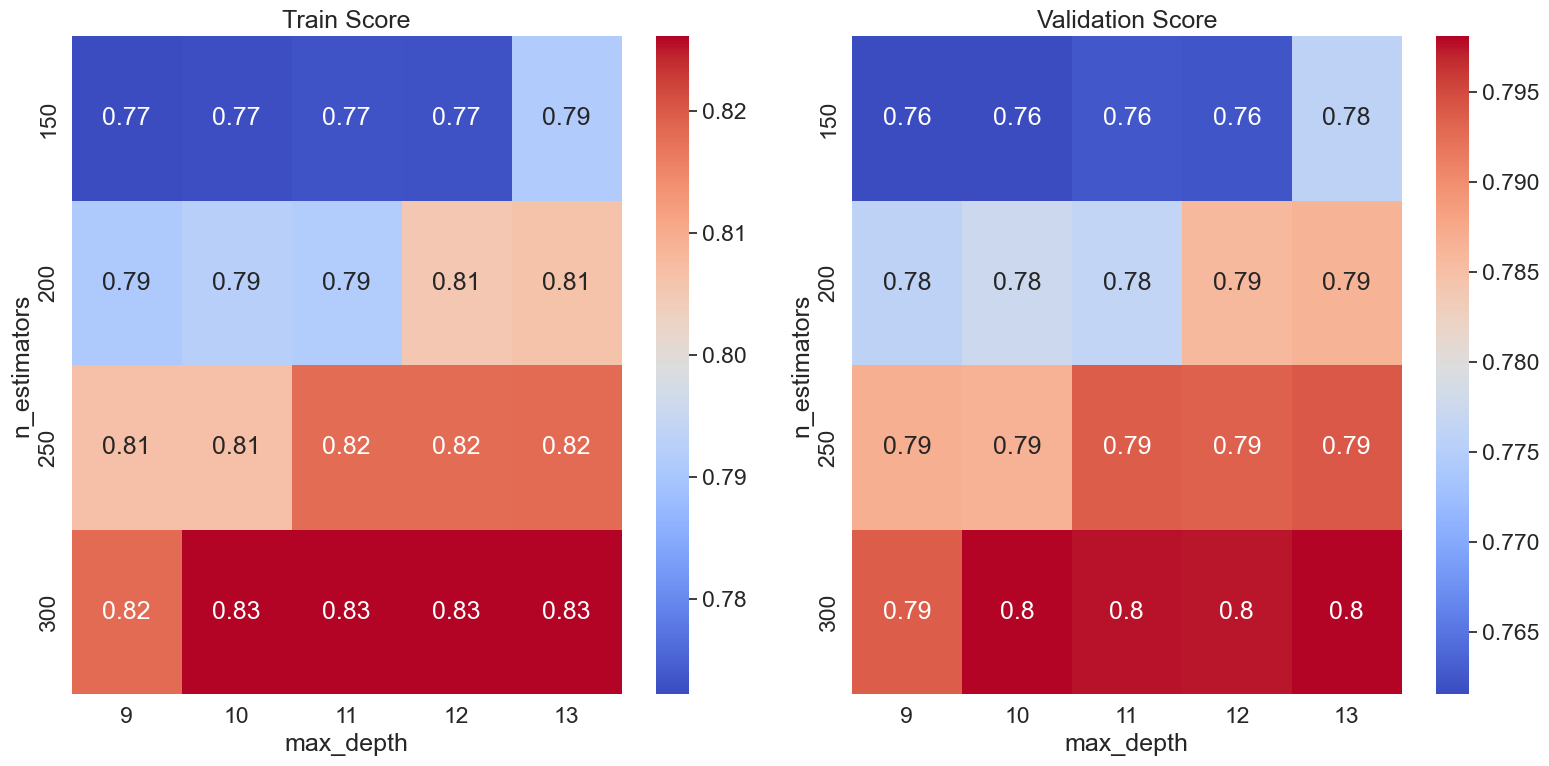

In [59]:
param_heat(rf_results, rf_param, 'max_depth', 'n_estimators')

## XGBoost 

In [60]:
from xgboost import XGBRegressor
xgb_params = {'max_depth' : range(8, 13), #6, 14
              'learning_rate' : [0.01, 0.05, 0.075, 0.1, 0.2] 
    }

xgb_results, xgb = training(XGBRegressor(n_estimators = 200, min_child_weight = 20), X_train, y_train, xgb_params)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
The best hyperparameters are: {'learning_rate': 0.05, 'max_depth': 8}
The best training score is: 0.8630460362475303
The best score is: 0.8212664283637027


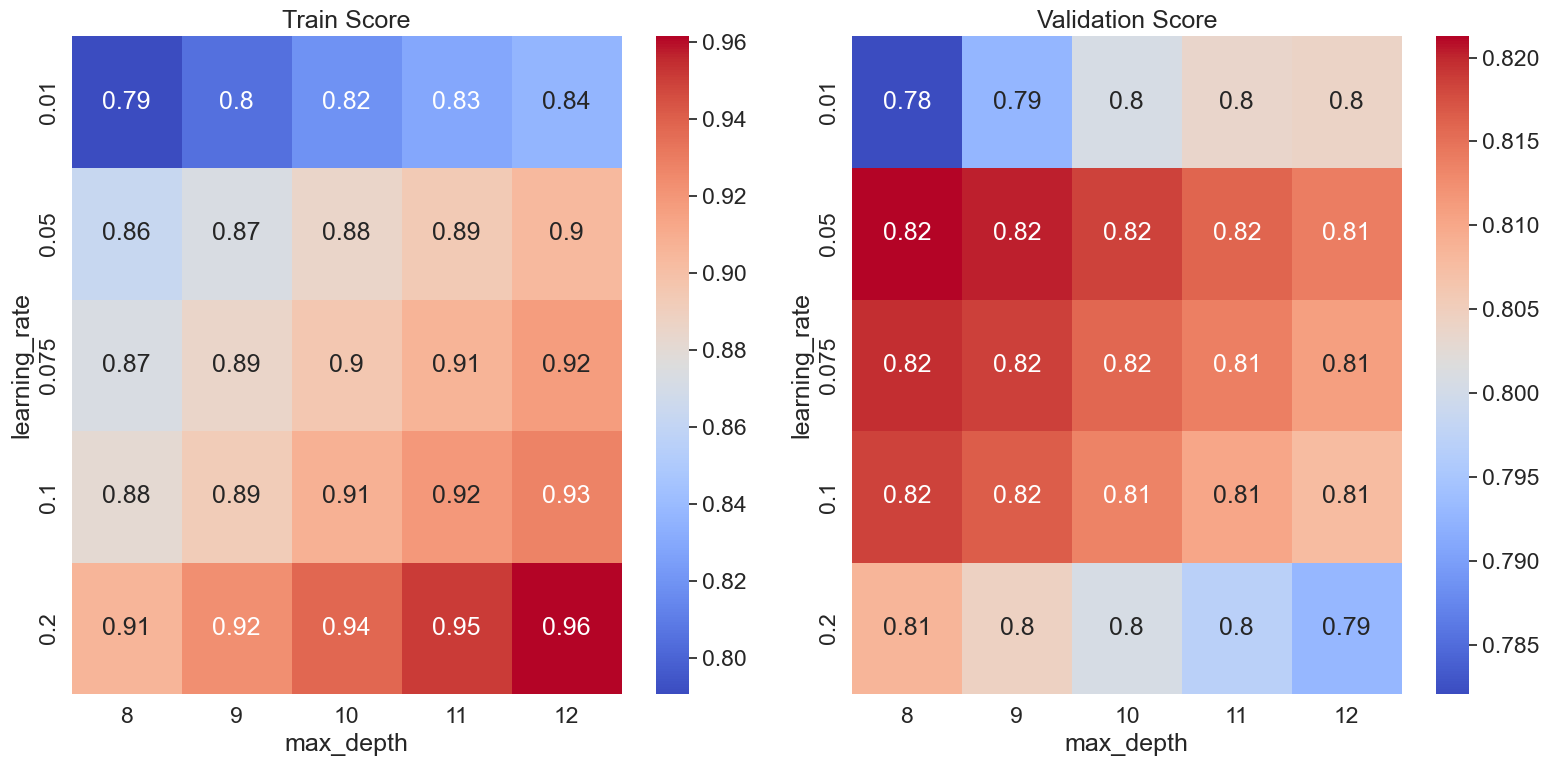

In [61]:
param_heat(xgb_results, xgb_params, 'max_depth', 'learning_rate')

As XGBoost had a better result we will choose this model to train

In [66]:
xgb_params = {'max_depth' : range(8, 13), 
              'learning_rate' : [0.05, 0.02, 0.04, 0.03, 0.06],
              'min_child_weight' : [5, 10],
              'reg_lambda' :[1, 10, 100]
              
    }

model_results, model = training(XGBRegressor(n_estimators = 200), X_train, y_train, xgb_params)

Fitting 4 folds for each of 150 candidates, totalling 600 fits
The best hyperparameters are: {'learning_rate': 0.04, 'max_depth': 10, 'min_child_weight': 10, 'reg_lambda': 100}
The best training score is: 0.8507778365321155
The best score is: 0.822869168045024


In the graph we observe that the results are similar for different hyperparameters

In [67]:
params_and_score = model_results[['param_max_depth', 'param_learning_rate', 'param_min_child_weight', 'param_reg_lambda', 'mean_test_score']]

params_and_score['param_max_depth'] = params_and_score['param_max_depth'].astype(int)
params_and_score['param_min_child_weight'] = params_and_score['param_min_child_weight'].astype(int)
params_and_score['param_reg_lambda'] = params_and_score['param_reg_lambda'].astype(float)
params_and_score['param_learning_rate'] = params_and_score['param_learning_rate'].astype(float)

fig = px.parallel_coordinates(params_and_score, 
                              dimensions=['param_max_depth', 'param_learning_rate', 'param_min_child_weight', 'param_reg_lambda', 'mean_test_score'],
                              color="mean_test_score", 
                              color_continuous_scale=px.colors.sequential.Viridis)

fig.show()


C:\Users\xavie\AppData\Local\Temp\ipykernel_17852\2018700196.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\xavie\AppData\Local\Temp\ipykernel_17852\2018700196.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\xavie\AppData\Local\Temp\ipykernel_17852\2018700196.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Make an adjust to see if we can get something better than the previous result

In [70]:
xgb_params = {'max_depth' : range(8, 12), 
              'learning_rate' : [0.035, 0.04, 0.045, 0.038], 
              'min_child_weight' : [10, 12],
              'reg_lambda' :[100, 1000]
              
    }

model_results, model = training(XGBRegressor(n_estimators = 200), X_train, y_train, xgb_params)

Fitting 4 folds for each of 32 candidates, totalling 128 fits
The best hyperparameters are: {'learning_rate': 0.045, 'max_depth': 10, 'min_child_weight': 10, 'reg_lambda': 100}
The best training score is: 0.8521541398151005
The best score is: 0.8229300911283355


# Result

In [71]:
model.score(X_test, y_test)

0.8210009582620463